In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }
inflation_target = 2
unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
annual_div = {"Q":4,
             "W":52,
             "M":12}
last_month = 1
next_month = -1
next_year = -12

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    # Create new variables
    data_gathered = True

ticker = "^GSPC"
data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["Currency in Circulation Growth Rate Diff (%)"] =  data["Currency in Circulation Growth Rate (%)"].diff(year)
data["Currency in Circulation Growth Rate Diff-in-Diff (%)"] =  data["Currency in Circulation Growth Rate Diff (%)"].diff(year)

data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)#.shift(last_month).dropna()
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)#.shift(last_month).mul(100).dropna()

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["Effective Federal Funds Rate Diff-in-Diff (%)"] = data["Effective Federal Funds Rate Diff (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Unemployment Rate Diff-in-Diff"] = data["Unemployment Rate Diff"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)

data["Inflation Loss Diff-in-Diff"]= data["Inflation Loss Diff"].diff(year)
data["Unemployment Loss Diff-in-Diff"]= data["Unemployment Loss Diff"].diff(year)
data["Inflation Loss Sq Diff-in-Diff"]= data["Inflation Loss Sq Diff"].diff(year)
data["Unemployment Loss Sq Diff-in-Diff"]= data["Unemployment Loss Sq Diff"].diff(year)


data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)
data["Linear Loss Diff-in-Diff"] = data["Linear Loss Diff"].diff(year)
data["Loss Function Diff-in-Diff"] = data["Loss Function Diff"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)



C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
data["Unemployment Rate"]

DATE
2002-12-31    6.0
2003-01-31    5.8
2003-02-28    5.9
2003-03-31    5.9
2003-04-30    6.0
             ... 
2021-05-31    5.8
2021-06-30    5.9
2021-07-31    5.4
2021-08-31    5.2
2021-09-30    0.0
Freq: M, Name: Unemployment Rate, Length: 226, dtype: float64

In [3]:
import yfinance as yfin
yfin.pdr_override()
data["S&P"]= web.get_data_yahoo(ticker, start = start, end = end).resample(freq).mean()["Close"].iloc[:-2]
data["S&P Growth Rate (%)"] = data["S&P"].pct_change(year)
data["S&P Growth Rate Change Diff (%)"] = data["S&P Growth Rate (%)"].diff(year)
data["Real S&P Growth Rate (%)"] = data["S&P Growth Rate (%)"].sub(data["Inflation (CPI)"])
data["VIX Diff"] = data["VIX"].diff(year)
data

[*********************100%***********************]  1 of 1 completed


,Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),Balance Sheet: Direct Lending ($ Mil),Balance Sheet: Unamortized Security Premiums ($ Mil),...,10 Year Minus 1 Year (%),10 Year Minus 3 Month (%),10 Year Minus 1 Month (%),10 Year Minus Effective Federal Funds Rate,Date,S&P,S&P Growth Rate (%),S&P Growth Rate Change Diff (%),Real S&P Growth Rate (%),VIX Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.00,0.0,52.00,10811.00,...,2.582381,2.821429,2.834762,2.793994,2002-12-31,899.178574,NaN,NaN,NaN,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.00,0.0,19.40,10688.00,...,2.684286,2.859524,2.878095,2.813410,2003-01-31,895.836190,NaN,NaN,NaN,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.50,0.0,10.50,10571.25,...,2.606316,2.717368,2.707368,2.640489,2003-02-28,837.618951,NaN,NaN,NaN,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.00,0.0,11.00,10619.25,...,2.567143,2.656190,2.630952,2.554240,2003-03-31,846.621425,NaN,NaN,NaN,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.20,0.0,31.80,10574.40,...,2.691429,2.806190,2.800476,2.700571,2003-04-30,890.025713,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,81423.00,349622.50,...,1.570500,1.603000,1.613500,1.562935,2021-05-31,4167.849536,0.427537,0.404802,-4.498970,-11.136500
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,87694.60,350797.60,...,1.452273,1.483182,1.491818,1.441091,2021-06-30,4238.489546,0.365202,0.290987,-4.959306,-14.162727
2021-07-31,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,87349.25,352744.75,...,1.242857,1.266190,1.269048,1.220507,2021-07-31,4363.712798,0.360421,0.289828,-4.922173,-9.237121


In [4]:
#fedProject
# . . . 
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])


<ipython-input-5-ab5c1d4011df>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


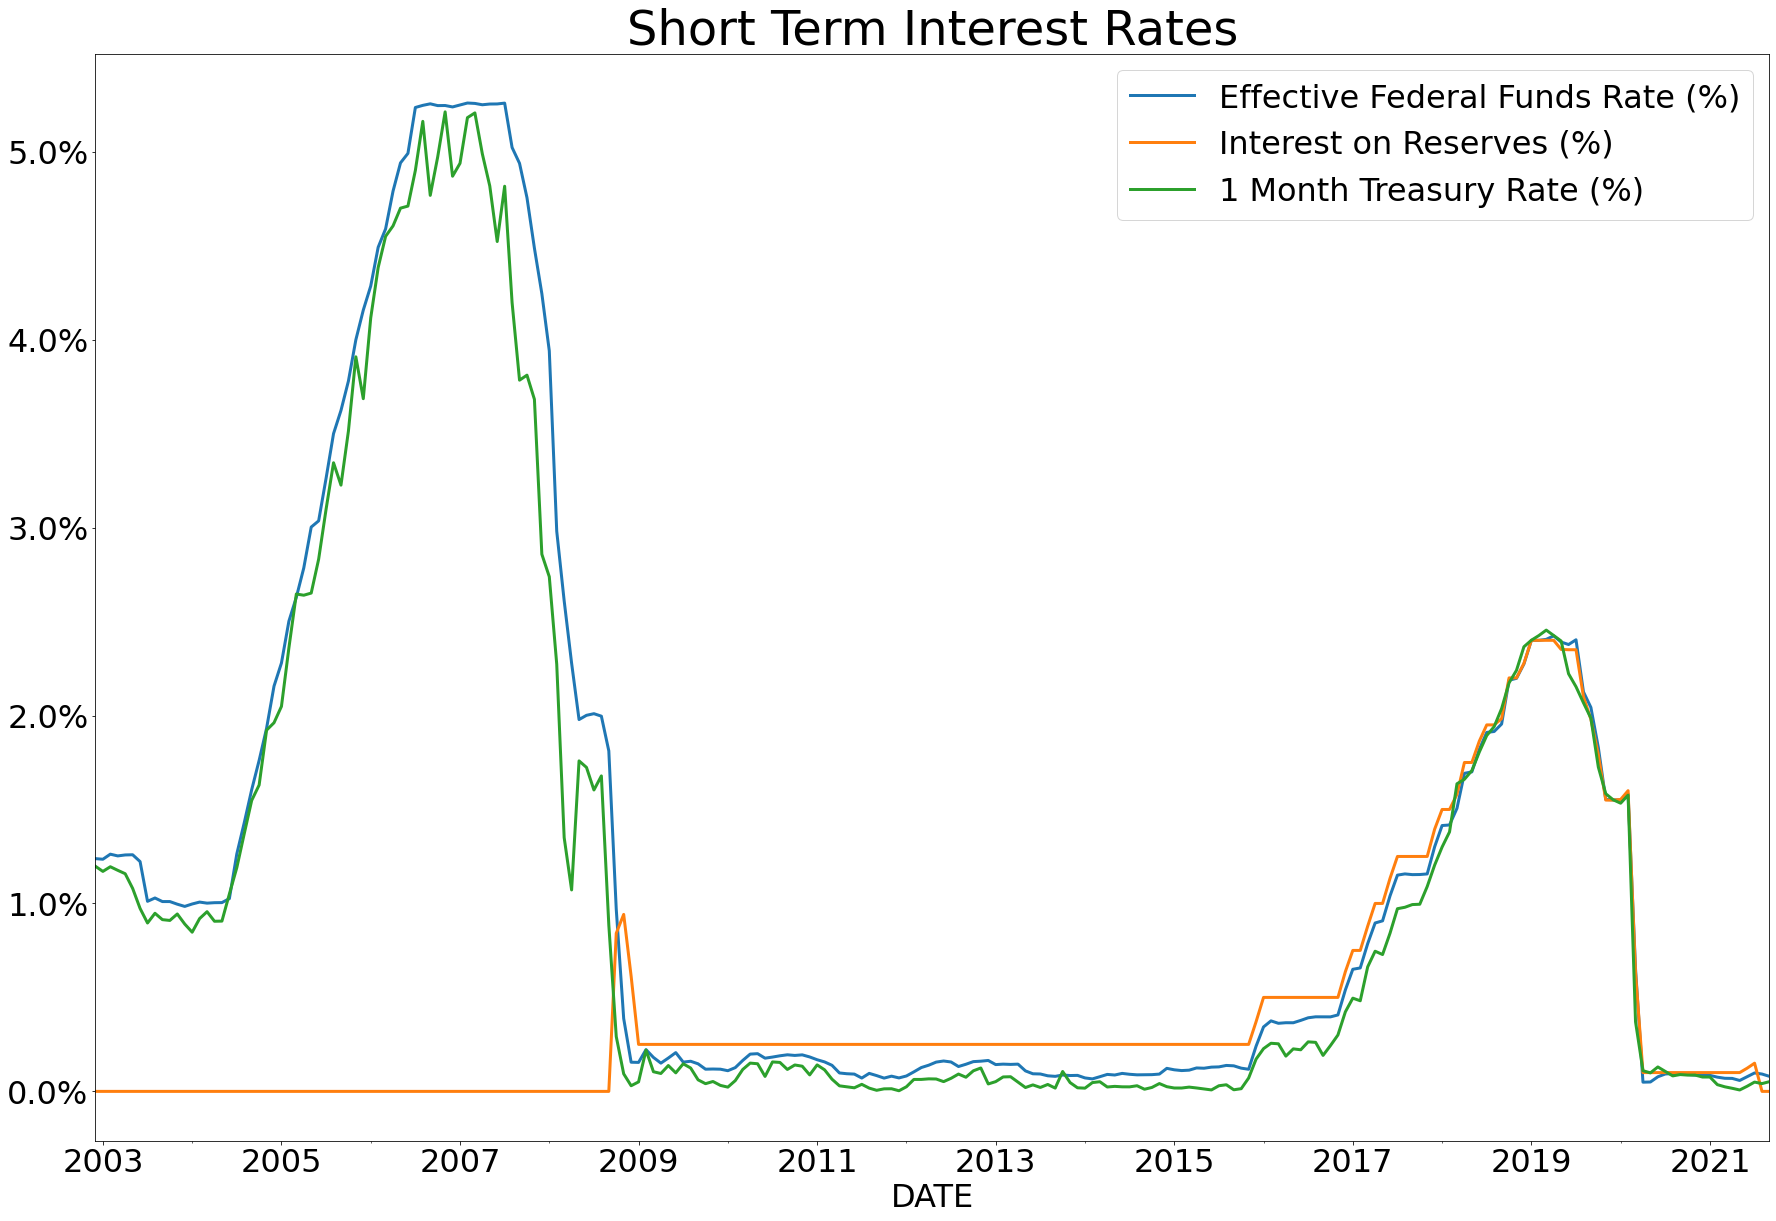

In [5]:
plt.rcParams.update({"font.size":32})
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [6]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

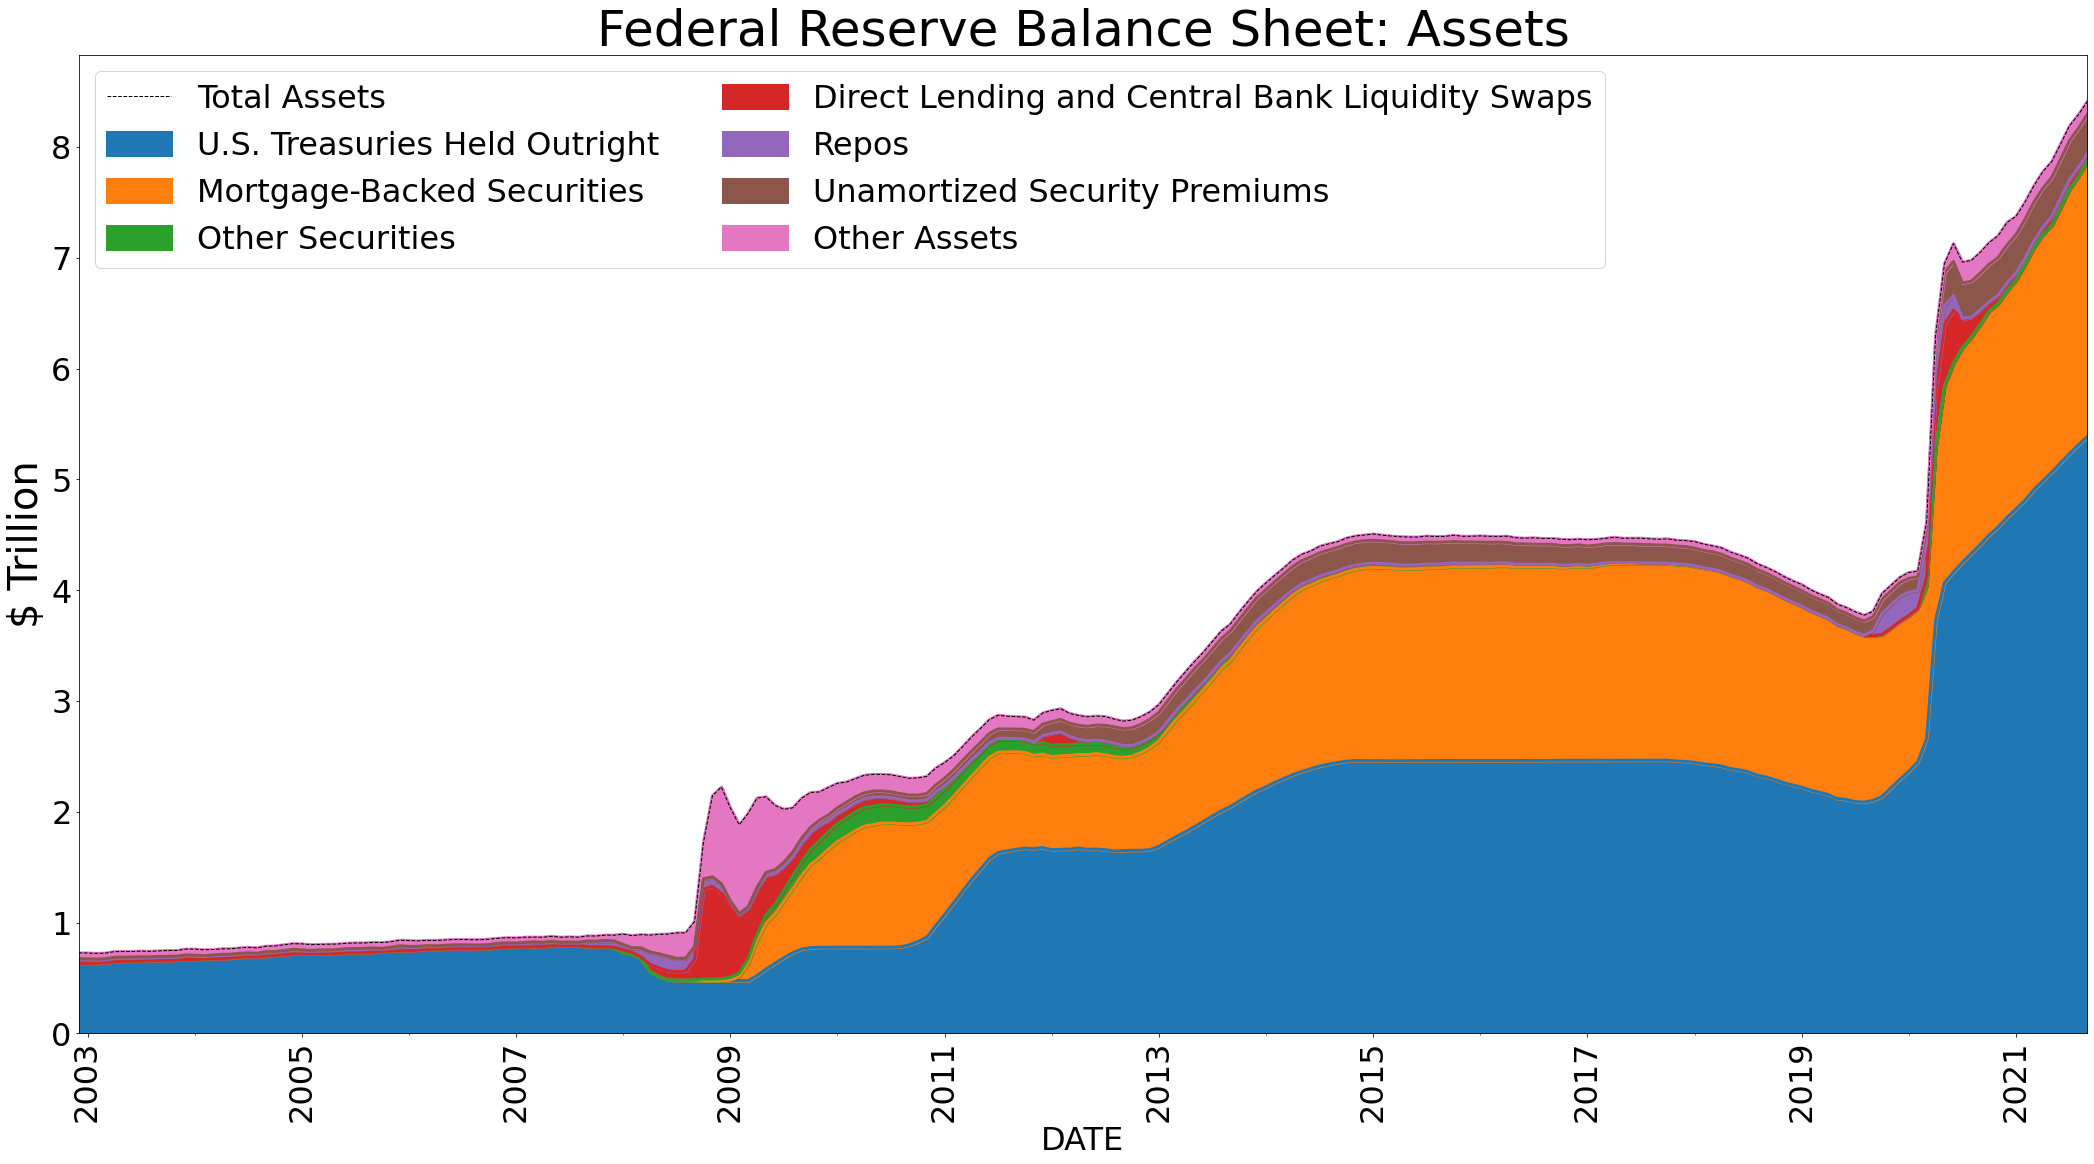

In [7]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

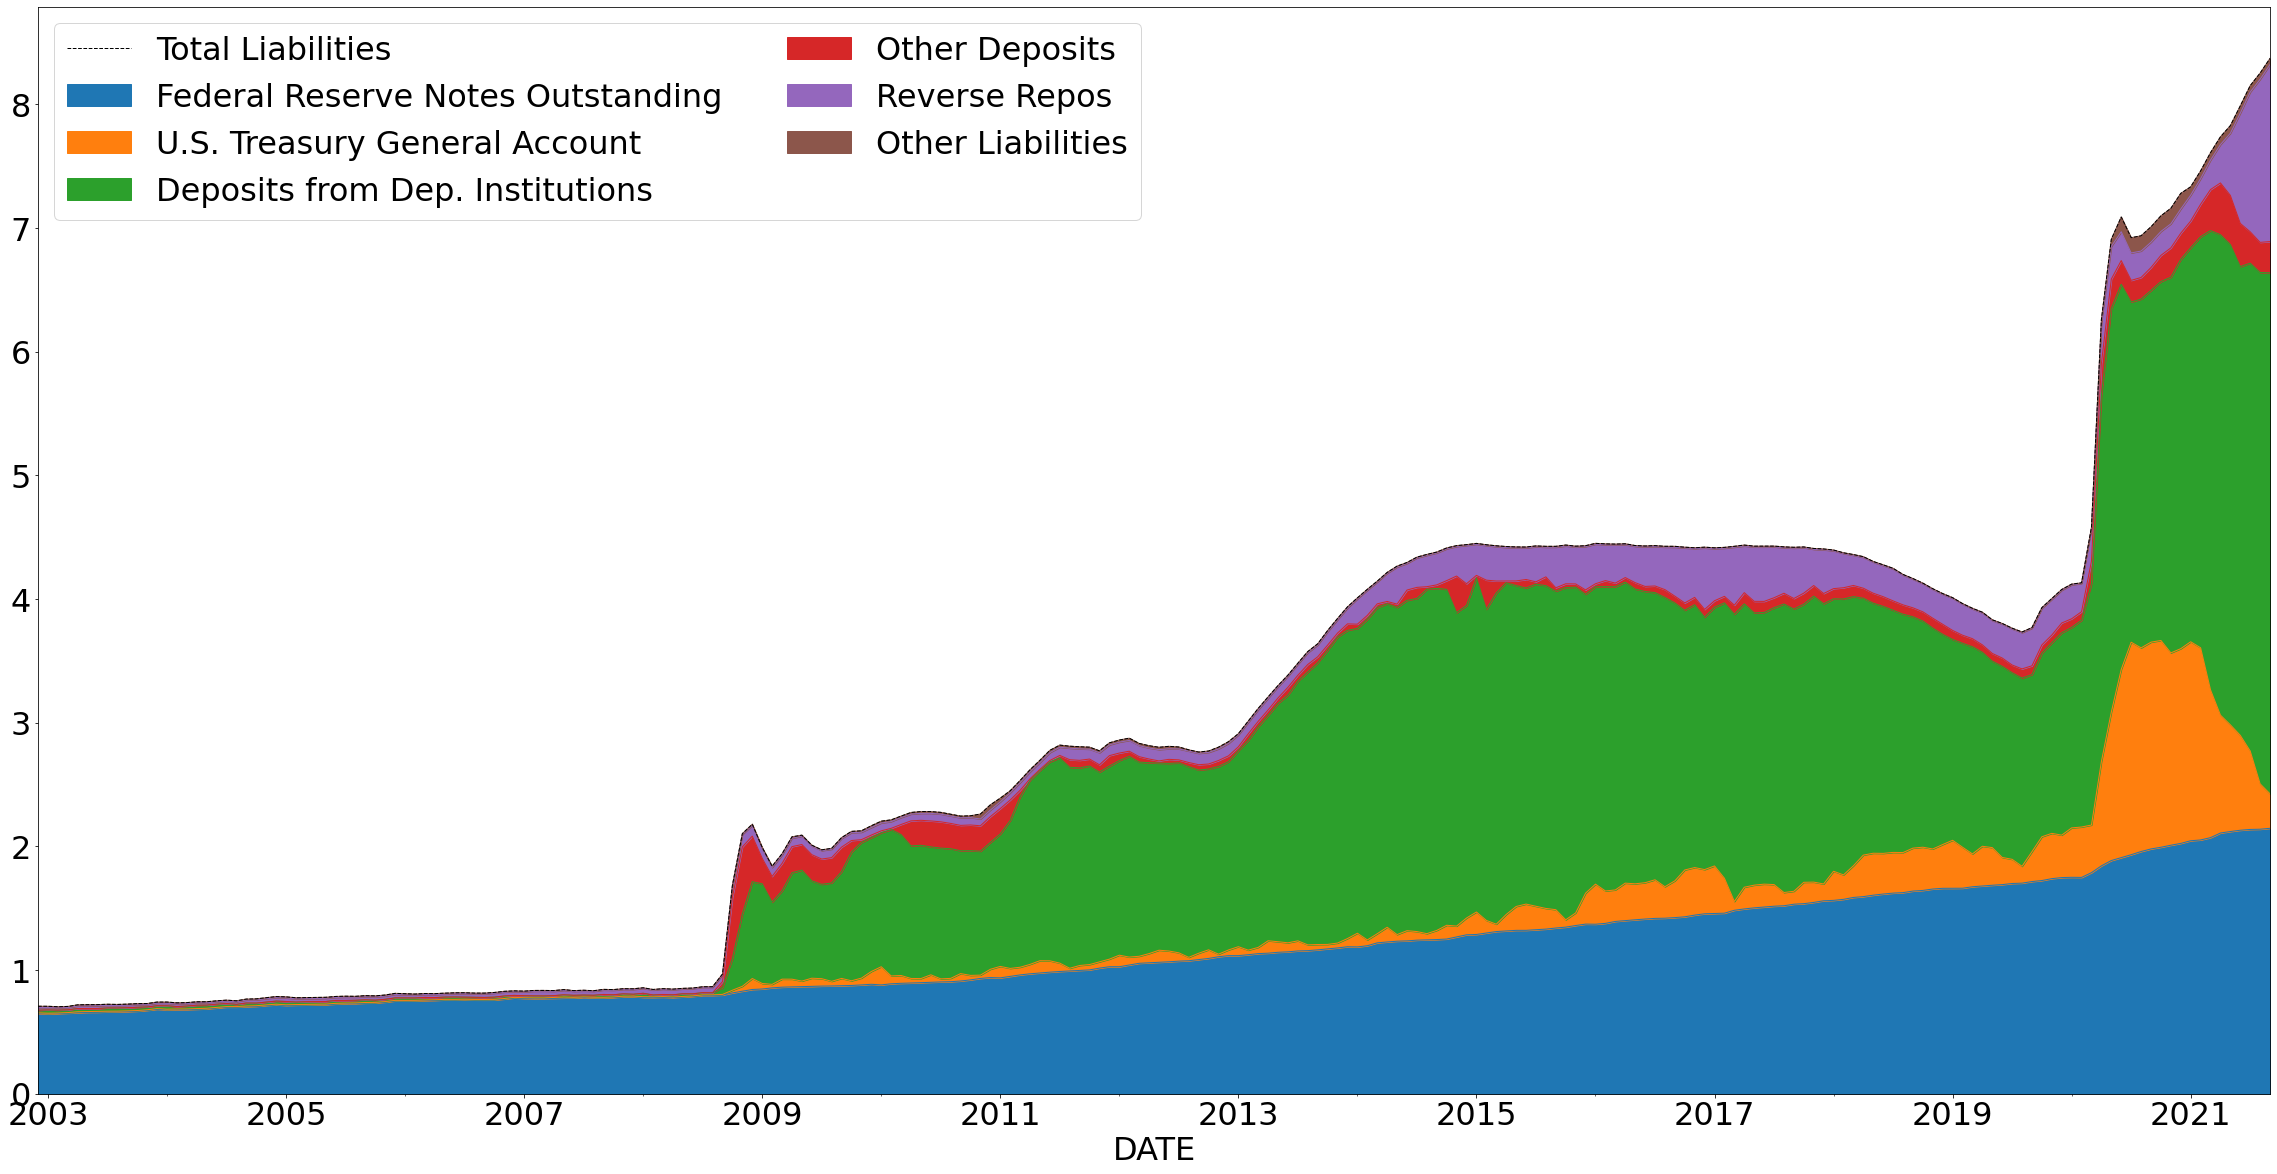

In [8]:
account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


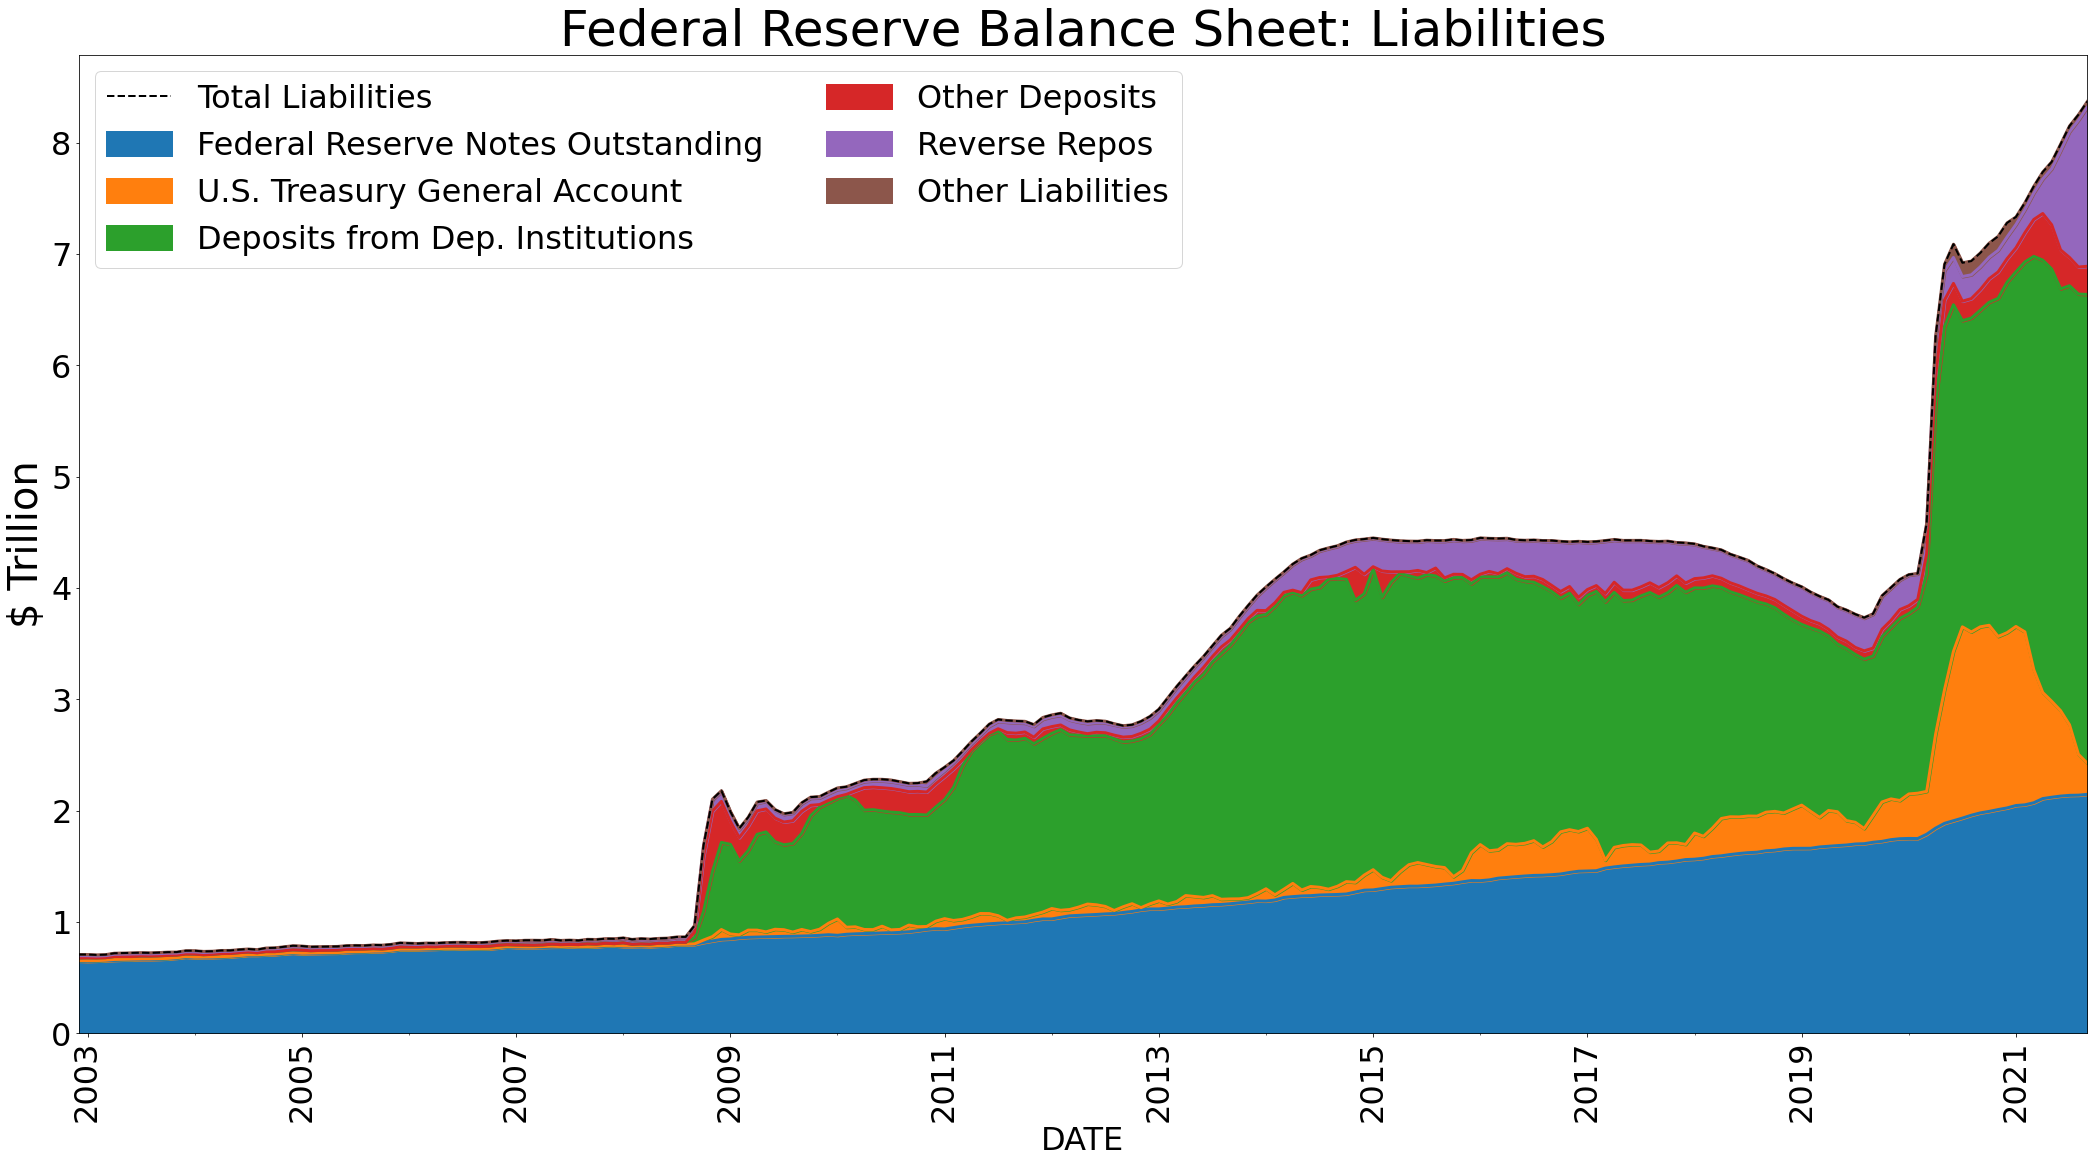

In [9]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

<ipython-input-10-bd89c59b9c46>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


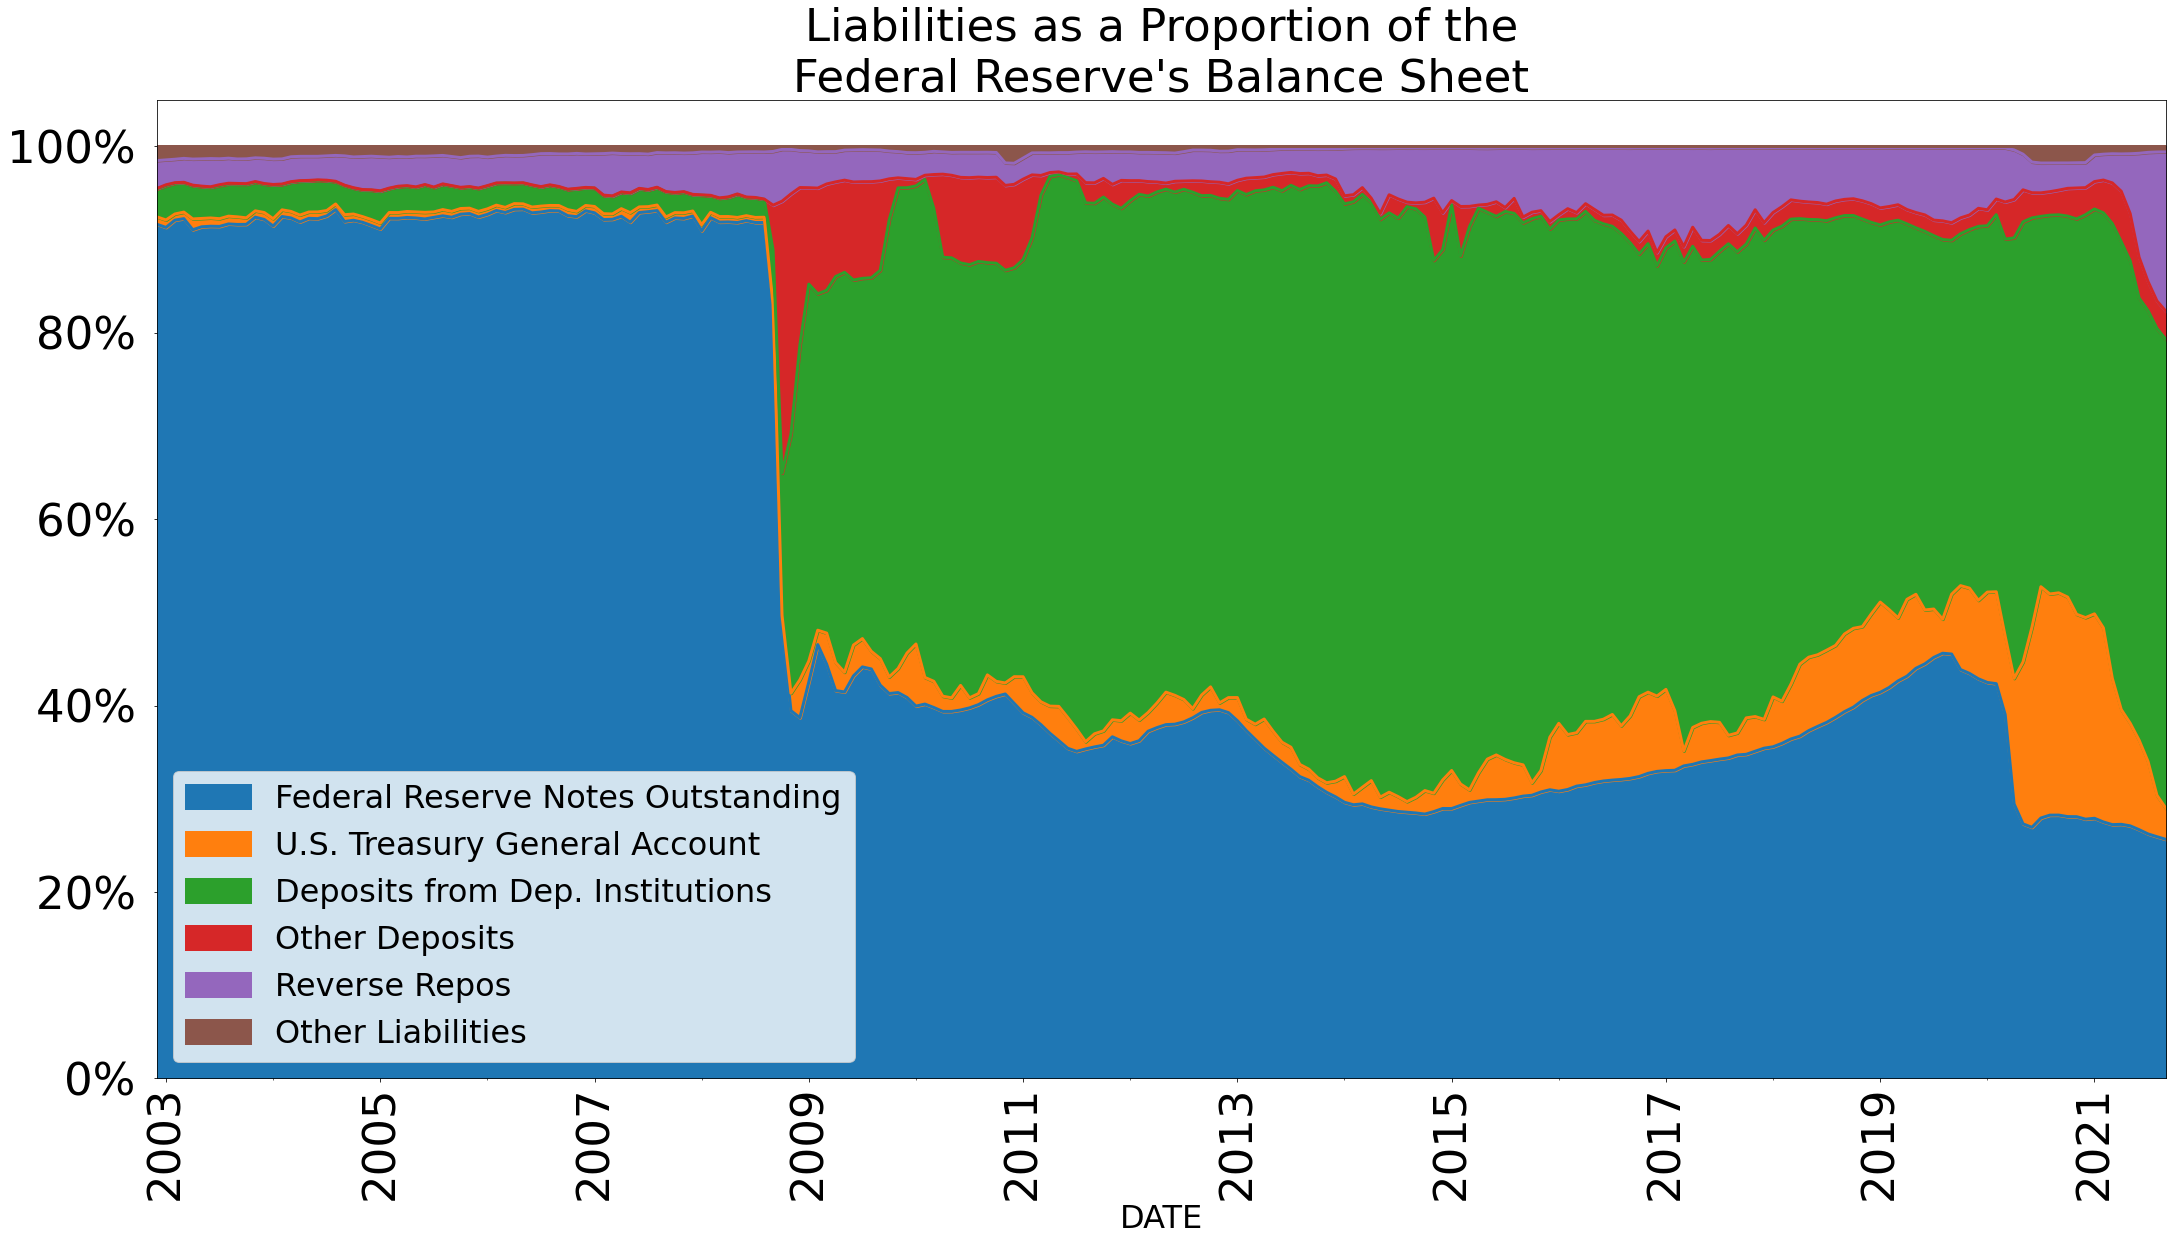

In [10]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


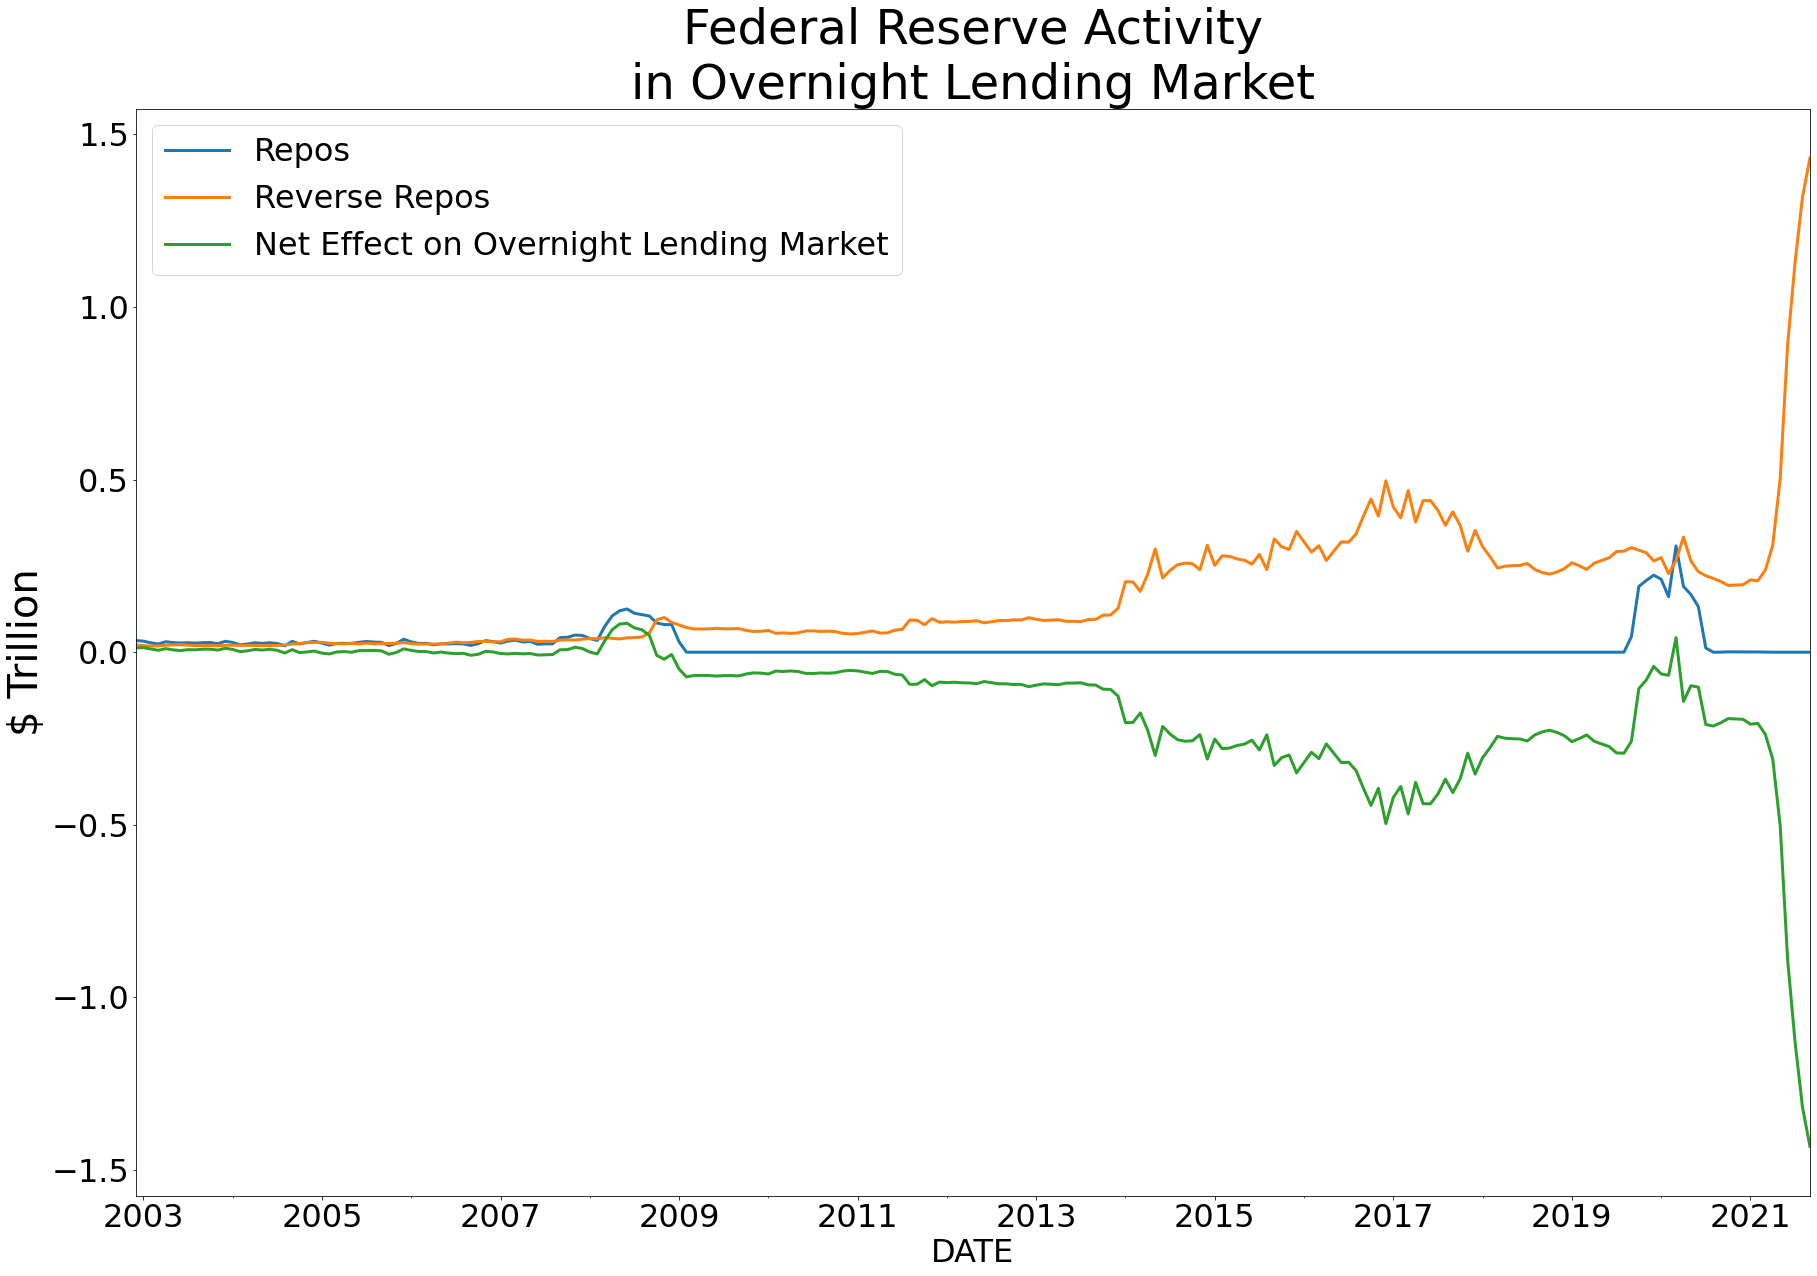

In [11]:
plot_data["Net Effect on Overnight Lending Market"] =\
    plot_data["Repos"].sub(plot_data["Reverse Repos"])
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


In [12]:
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Assets Growth Rate Diff (%)"] = data["Total Assets Growth Rate (%)"].diff(year)
data["Total Assets Growth Rate Diff-in-Diff (%)"] = data["Total Assets Growth Rate Diff (%)"].diff(year)

data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"]).mul(100)
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Assets Diff-in-Diff"] = data["Currency in Circulation / Total Assets Diff"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()


In [13]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
data

,Total Assets,"Balance Sheet Securities, Prem-Disc, Repos, and Loans",Securities Held Outright,U.S. Treasuries Held Outright,Federal Agency Debt Securities,Mortgage-Backed Securities,Repos,Central Bank Liquidity Swaps,Direct Lending,Unamortized Security Premiums,...,Total Assets Growth Rate (%),Total Assets Growth Rate Diff (%),Total Assets Growth Rate Diff-in-Diff (%),Total Liabilities / Currency in Circulation,Total Assets / Currency in Circulation,Currency in Circulation / Total Assets,Currency in Circulation / Total Assets Diff,Currency in Circulation / Total Assets Diff-in-Diff,Currency in Circulation / Total Liabilities,Currency in Circulation / Total Liabilities Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.00,0.0,52.00,10811.00,...,NaN,NaN,NaN,1.046535,1.072920,93.203573,NaN,NaN,0.955534,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.00,0.0,19.40,10688.00,...,NaN,NaN,NaN,1.041374,1.066686,93.748330,NaN,NaN,0.960270,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.50,0.0,10.50,10571.25,...,NaN,NaN,NaN,1.035709,1.061035,94.247573,NaN,NaN,0.965522,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.00,0.0,11.00,10619.25,...,NaN,NaN,NaN,1.033573,1.058878,94.439552,NaN,NaN,0.967518,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.20,0.0,31.80,10574.40,...,NaN,NaN,NaN,1.047029,1.072587,93.232567,NaN,NaN,0.955083,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,81423.00,349622.50,...,0.132325,-0.662117,-1.565150,3.610492,3.628665,27.558344,-0.217304,16.747691,0.276971,-0.002350
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,87694.60,350797.60,...,0.126094,-0.729082,-1.694133,3.665537,3.683695,27.146654,-0.286407,17.509885,0.272811,-0.003025
2021-07-31,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,87349.25,352744.75,...,0.176703,-0.653170,-1.595879,3.728183,3.746297,26.693025,-1.728609,15.775106,0.268227,-0.017582


In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
p_val = .01
def formatted_scatter_matrix(data, pp, title = ""):  
    # Create a figure showing scatterplots given in scatter_cats  
    fig_len = 12  
    fig, ax = plt.subplots(figsize = ((fig_len, fig_len)))  
    # Use fig_len to dictate fig_size, adjust size of font, size of dots, etc...  
    num_vars = len(data.keys())  
    fontsize = 26
    plt.rcParams.update({'font.size': fontsize})  
    pd.plotting.scatter_matrix(data.rename(columns={col:col.replace(" ", "\n") for col in data})
                               ,alpha = .5, s = 200 / num_vars, ax=ax)  
    # tight layout improves layout of text and plots in the figure  
    plt.suptitle(title)
    plt.tight_layout()  
    plt.show()  
    pp.savefig(fig, bbox_inches = "tight")  
    plt.close() 

def corr_matrix_heatmap(data, pp, title = "Correlation"):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(12,12))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(data, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = data.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(data.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "k")#, alpha = 1 - round(abs(data.values[i][j]),2))  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title(title, fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    pp.savefig(fig, bbox_inches="tight")
    plt.close()

def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    d_sep = {}
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            d_sep[(x,y)] = []

            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, y = y, covar = None,method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                ############## make recursive function #############

                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

def adfuller_df(df, maxlag = 12):
    dct = {}
    for key, val in df.items():
        dct[key] = adfuller(val, maxlag=maxlag, autolag = "aic")[1]#.pvalue
    return dct

def cointegration_df(df):
    dct = {}
    for key1 in df:
        dct[key1] = {}
        for key2 in df:
            if key1 == key2:
                dct[key1][key2] = np.nan
            else:
                dct[key1][key2] = coint_johansen(df[[key1,key2]], det_order=0, k_ar_diff=1).lr1
    return pd.DataFrame(dct)
# undirected_graph = build_skeleton(df, undirected_graph)                                   
# undirected_graph


In [17]:
# cointegration_df(var_data)


In [24]:
rename_dct = {"Effective":"FFR",
             "Circulation / Total":"C/A",
              "Circulation Growth":"C",
             "Assets Growth":"A",
              "Function":"LF",
              
             "Inflation":"$\pi$",
             "Unemployment":"U"}
diffs = ["", " Diff", " Diff-in-Diff"]
adf_dct = {}
for diff in diffs:
    plot_vars_dct = {"Augmented Dickey Fuller": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff]}
    adf_dct[diff]={}
    for i in plot_vars_dct:
        var_data = data[plot_vars_dct[i]].dropna()#.loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    dif = diff if "Diff" in key else""
                    lag = " Lag" if "Lag" in key else ""
                    var_data.rename(columns={key:rename_dct[rename_key]+dif + lag}, inplace = True)

        adf_dct[diff][i] = {}
        for j in range(0,12):
            adfuller_stats = adfuller_df(var_data.iloc[j::12], 1) 
            adf_dct[diff][i][j]=adfuller_stats
#             print(j,pd.DataFrame(adfuller_stats, index = [0]), sep = "\n")
        adf_dct[diff][i] = pd.DataFrame(adf_dct[diff][i]).T
        adf_dct[diff][i].rename(index={0:12}, inplace = True)
        adf_dct[diff][i].sort_index(inplace = True)
        adf_dct[diff][i].index.name= "Month"


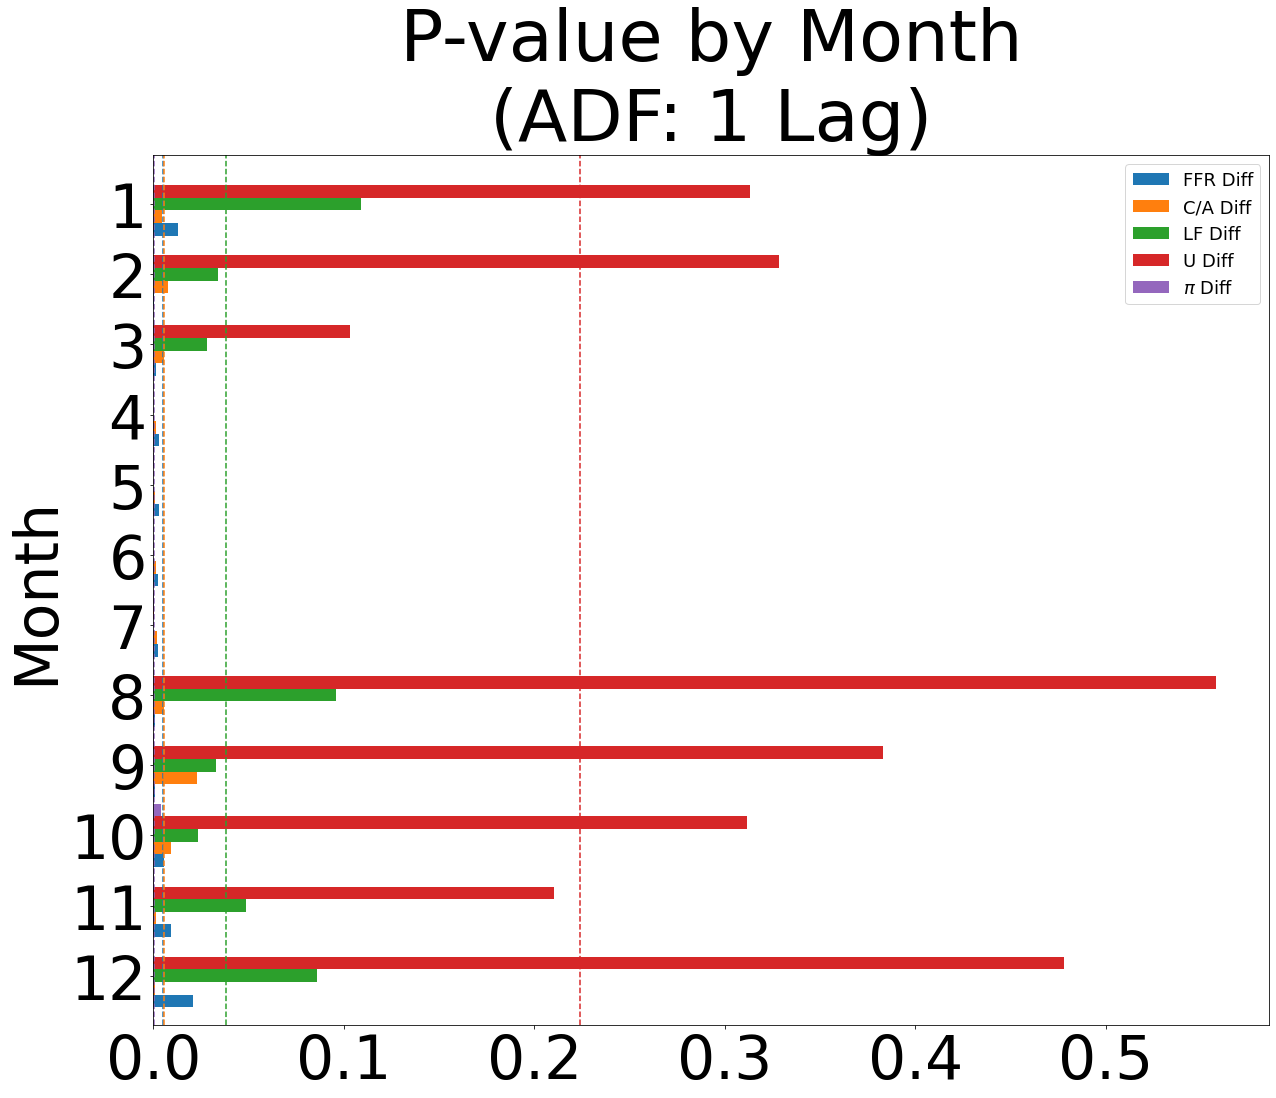

In [28]:
fig,ax = plt.subplots(figsize = (20,16))
adf_dct[" Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).plot.barh(legend = False, width =.9, ax=ax)
plt.legend(fontsize = 18)
plt.title("P-value by Month\n(ADF: 1 Lag)")

mean_vals = adf_dct[" Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).mean()
for i in range(len(mean_vals)):
    val = mean_vals[i]
    ax.axvline(val, color = "C" + str(i), ls = "--")

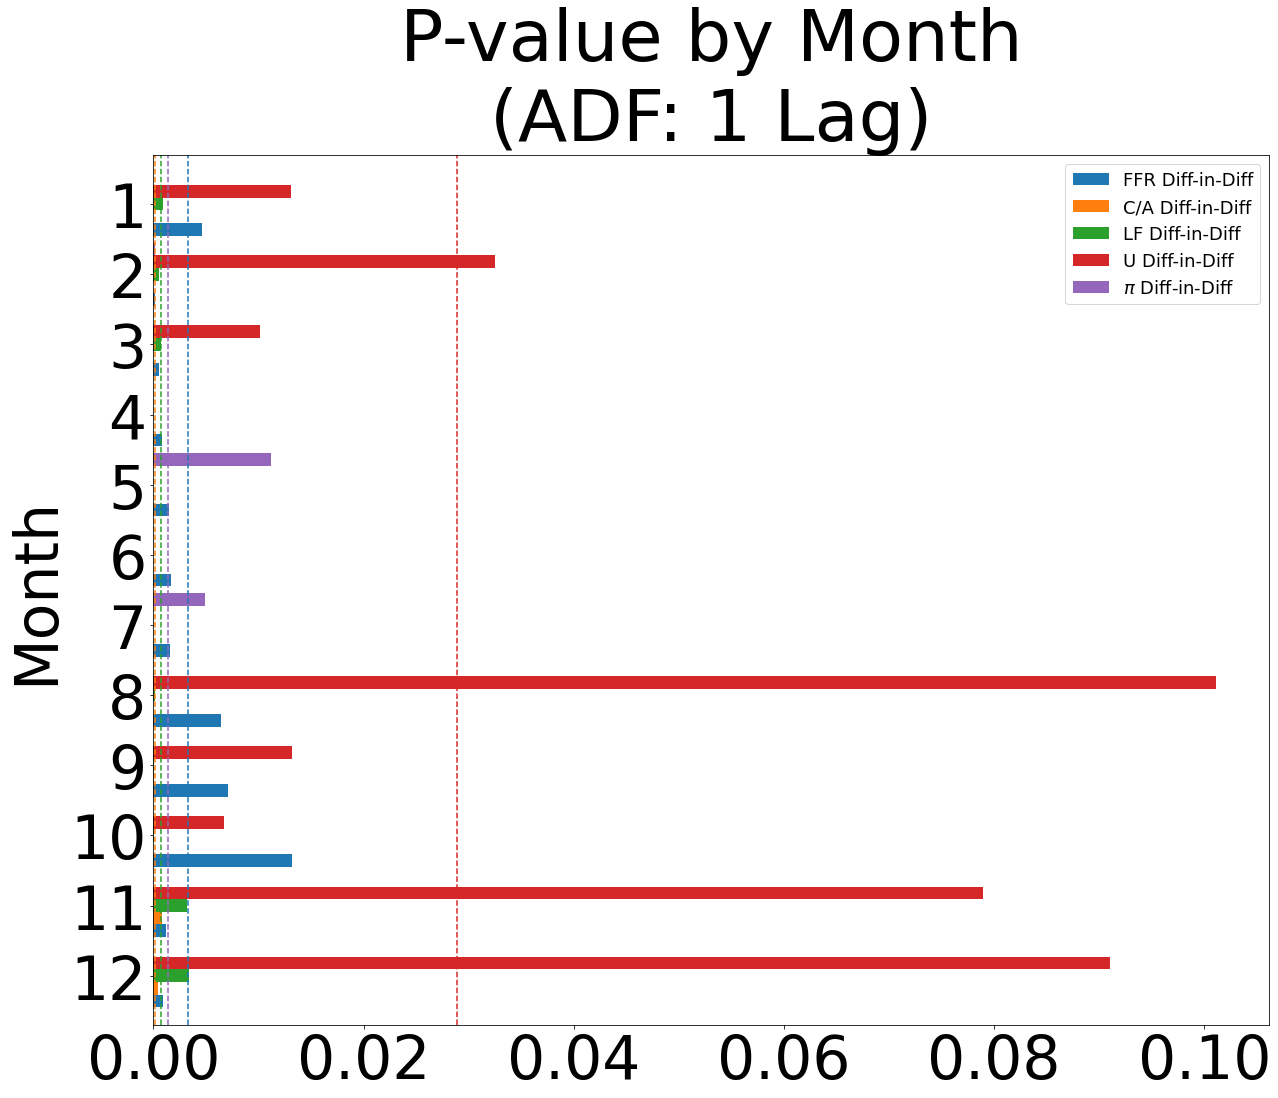

In [29]:
fig,ax = plt.subplots(figsize = (20,16))
adf_dct[" Diff-in-Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).plot.barh(legend = False, width =.9, ax=ax)
plt.legend(fontsize = 18)
plt.title("P-value by Month\n(ADF: 1 Lag)")

mean_vals = adf_dct[" Diff-in-Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).mean()
for i in range(len(mean_vals)):
    val = mean_vals[i]
    ax.axvline(val, color = "C" + str(i), ls = "--")

Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 1: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 32.01it/s]


keep control: FFR
('LF', 'C/A') ['FFR']
keep control: LF
('FFR', 'C/A') ['LF']


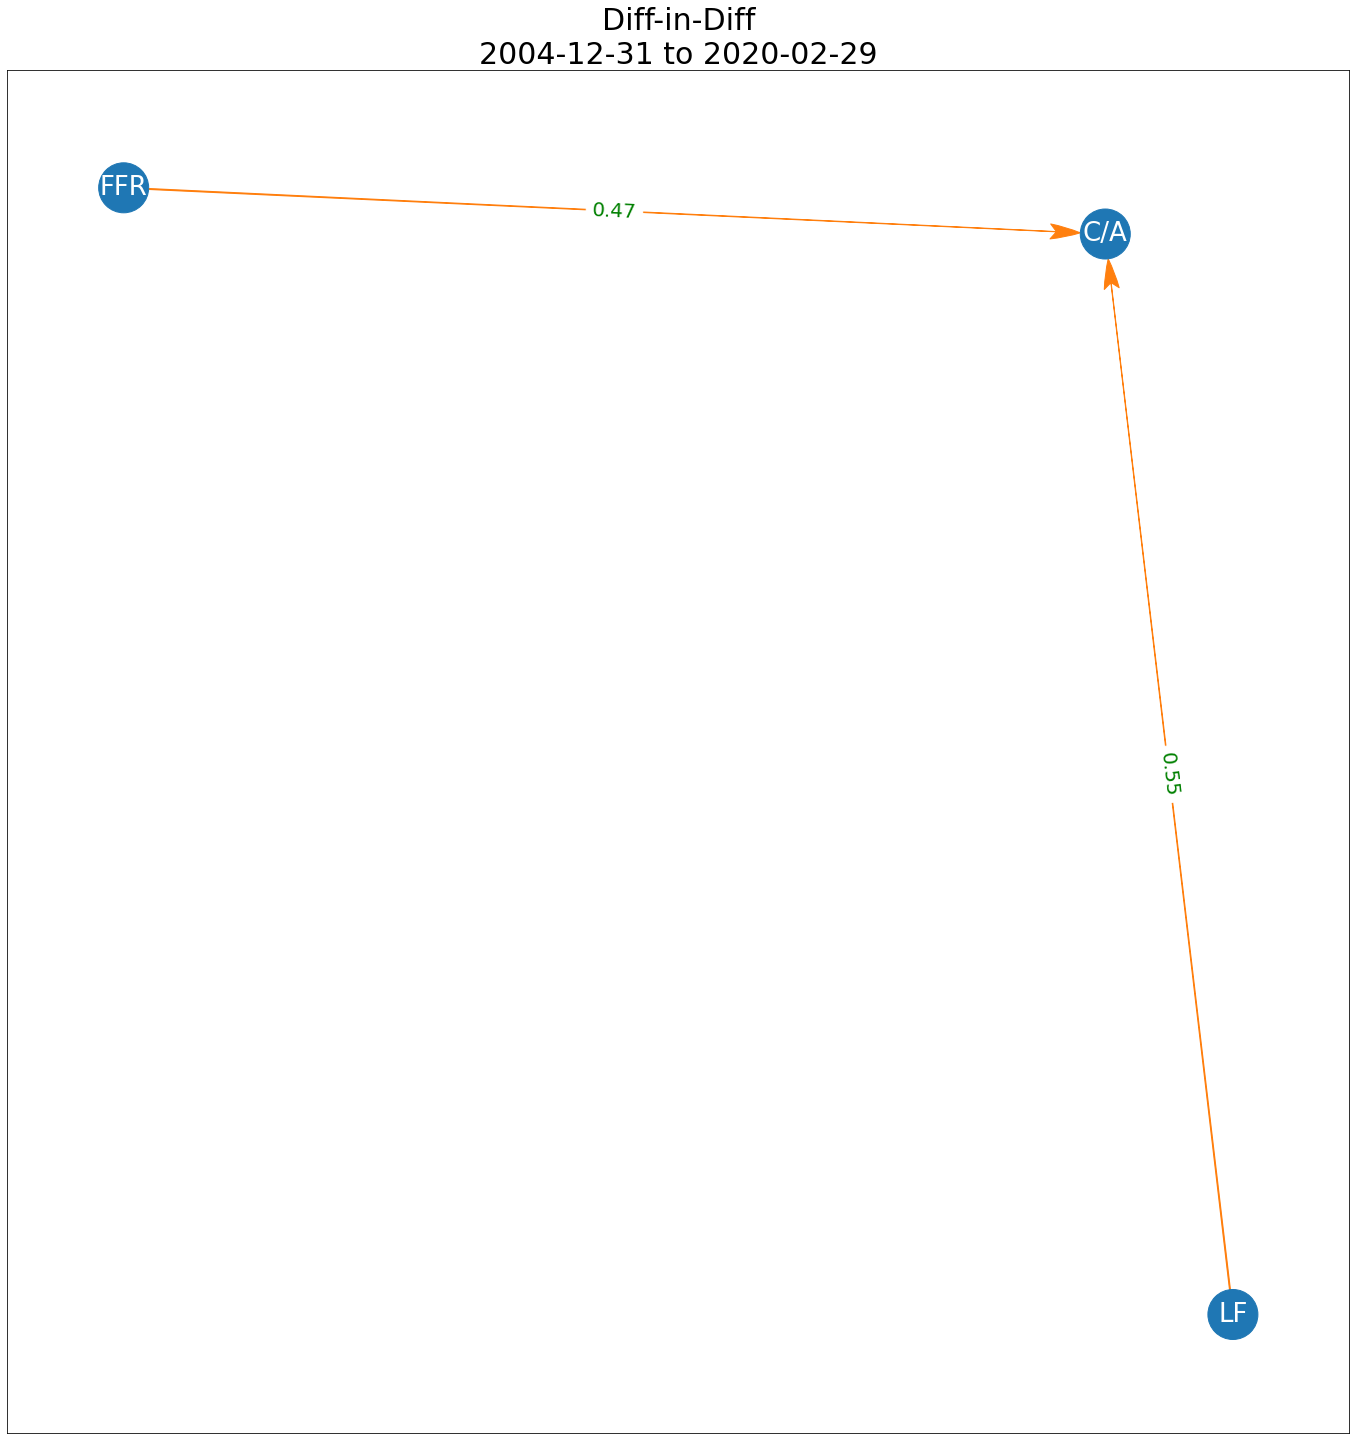

Index(['FFR', 'C/A', 'LF'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    FFR   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     26.27
Date:                Tue, 28 Sep 2021   Prob (F-statistic):           9.78e-11
Time:                        08:53:22   Log-Likelihood:                -287.60
No. Observations:                 183   AIC:                             581.2
Df Residuals:                     180   BIC:                             590.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C/A     

KeyError: "['Constant'] not in index"

In [34]:
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({"font.size":20})

from matplotlib.patches import ArrowStyle
def graph_DAG(edges, df, pp, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    pp.savefig(fig, bbox_inches = "tight")  
    plt.show()
    plt.close()

def add_lags(data, lags=1):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            var_data[new_key] = var_data[key].shift(year * i)

def rename_vars(data, rename_dct):
    for key in data:
        for rename_key in rename_dct:
            if rename_key in key:
                data.rename(columns={key:rename_dct[rename_key]}, inplace = True)                

def DAG(data, variant, ci_test, sig):
    c = PC(data)
    max_cond_vars = len(data.keys()) - 2
    model = c.estimate(return_type = "dag",variant= variant, 
                       significance_level = sig, 
                       max_cond_vars = max_cond_vars, ci_test = ci_test)
    edges = model.edges()
    return edges

def identify_sink_nodes(edges):
    unzipped_edges = list(zip(*edges))
    source_nodes = unzipped_edges[0]
    sink_nodes = unzipped_edges[1]
#     sink_nodes = [node for node in sink_nodes if node not in source_nodes]
    caused_causal = {node:[] for node in sink_nodes}
    for source, sink in edges:
#         if sink in sink_nodes:
        caused_causal[sink].append(source)
                
    return caused_causal 

def simultaneous_OLS(df, keys, model="DAG" ):
    reg_dict={} 
    residuals = {}
    for key in keys:
        print(df.keys())
        
        reg_dict[key] = {}
        Y = df[[key]]
        DAG_vars = [k for k in keys if  k != key]  
        VAR_vars = [k + " Lag" for k in keys]
        if model == "DAG":
            X_vars = DAG_vars
        elif model == "VAR":
            X_vars = VAR_vars
        X = df[X_vars]
        X["Constant"] = 1
        X_vars = X_vars + ["Constant"]
        model = sm.OLS(Y,X)
        results = model.fit()
        print(results.summary())
        residuals[key] = results.resid
        for j in range(len(X_vars)):
            x_var = X_vars[j]
            reg_dict[key][x_var] = str(round(results.params[j], 3))


        # add * ** *** to sig values
            sig_vals = [.05, .01, .001]
            for sig_val in sig_vals:
                if results.pvalues[j] < sig_val: 
                    reg_dict[key][x_var] = reg_dict[key][x_var] + "*"        
        reg_dict[key]["r2_adj"] = round(results.rsquared_adj,2)
    return reg_dict, residuals

def DAG_OLS(ols_df, filename, pp):
    keys = list(ols_df.keys())
    reg_dict, residuals = simultaneous_OLS(ols_df, keys, model = "DAG")
        
    reg_dict = pd.DataFrame(reg_dict).T[keys + ["Constant", "r2_adj"]].T
    reg_dict.to_excel(filename + ".xlsx")
    residuals = pd.DataFrame(residuals)    
    res_corr = residuals.corr()
    pval_corr = residuals.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)

    formatted_scatter_matrix(residuals[keys], pp, dates +"\nDAGOLS Residuals")
    corr_matrix_heatmap(res_corr, pp, dates + "\nDAGOLS Partial Correlations")
    corr_matrix_heatmap(pval_corr, pp, dates +"\np-values")    

def DAG_var(df, sink_source, filename):
    for sink, source in sink_source.items():
        variables = [sink] + source
        for k in range(len(variables)):
            key = variables[k]
            variables.append(key + " Lag")

        ols_df = df[variables]
        ols_df.dropna(inplace = True)
        keys = [key for key in variables if "Lag" not in key]
        reg_dict, residuals = simultaneous_OLS(ols_df, keys,model = "VAR")

        lag_keys = [key + " Lag" for key in keys] + ["Constant"]     
        excel_df = pd.DataFrame(reg_dict).T[lag_keys + ["r2_adj"]].T
        filename = str(variables) + filename + ".xlsx"
        excel_df.to_excel(filename.replace("/",""))
        residuals = pd.DataFrame(residuals) 
        res_corr = residuals[keys].corr()
        pval_corr = residuals[keys].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)
        formatted_scatter_matrix(residuals[keys], pp, dates +"\nVAR Residuals")
        corr_matrix_heatmap(res_corr, pp, dates + "\nVAR Residual Correlations")
        corr_matrix_heatmap(pval_corr, pp, dates + "\np-values")
        
start_end_list = [(str(var_data.index[0])[:10], "2020-02-29"),
                  (str(var_data.index[0])[:10],"2008-09-30"),
                  ("2008-10-31", "2020-02-29"),
                  ("2010-01-31", "2020-02-29")]
                
diffs = [" Diff-in-Diff"]
# diffs = [" Diff"]
pp = PdfPages("MacroDAGs.pdf")
reg_dict = {}
lags = 1

for diff in diffs:
    reg_dict[diff] = {}
    plot_vars_dct = {"Aggregated C-A": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
                     "Aggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
                        "Loss Function" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Total Assets Growth Rate" +diff + " (%)"],
                     "Disaggregated C-A":["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

                     "Disaggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
                        "Unemployment Loss Sq" + diff,
                        "Inflation Loss Sq" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Total Assets Growth Rate" +diff + " (%)"],
                    }

    sig = 0.05
    variant = "parallel"
    ci_test = "pearsonr"
    
    for i, plot_vars in plot_vars_dct.items():
        reg_dict[diff][i] = {}
        
        var_data = data[plot_vars].dropna()
        rename_vars(var_data, rename_dct)
        add_lags(var_data, lags)
                    
#         start_end_list = [("2010-01-31", "2020-02-29")]

        dfs = {}
        for start,end in start_end_list:
            dfs[start +" to " + end] =  var_data.loc[start:end] 

        for dates, df in dfs.items():
            keys = [k for k in df if "Lag" not in k]
            dag_df = df[keys]#.rename(columns={key: key.replace(" Diff-in-Diff", "") for key in dag_keys})
            edges = DAG(dag_df, variant, ci_test, sig)
            graph_DAG(edges, dag_df, pp = pp, title = diff.replace(" ", "") + "\n" + dates)
            filename = i + " " + diff + "DAGOLS " + dates 
            DAG_OLS(dag_df, filename, pp)            
            sink_source = identify_sink_nodes(edges)
            filename = i + " " + diff + "DAGVAR " + dates 
            DAG_var(df, sink_source, filename)
            # run VAR/VARs

    #     print(pd.DataFrame(reg_dict[diff][i]))
pp.close()

In [ ]:
var_data

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
data.loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Total Assets Growth Rate Diff-in-Diff (%)", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "Effective Federal Funds Rate Diff-in-Diff (%)", 
                                                 cmap = "viridis", 
                                                 ax = ax)

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
data[data["Effective Federal Funds Rate (%)"] <= 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C0", 
                                                 ax = ax)
data[data["Effective Federal Funds Rate (%)"] > 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C2", 
                                                 ax = ax)

In [ ]:
data2

In [ ]:

pp = PdfPages("LAGResiduals.pdf")

# diffs = ["", " Diff"]
diffs = [" Diff-in-Diff"]

reg_dict = {}
for diff in diffs:
    plot_vars_dct = {"Aggregated C-A": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
                     "Aggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
                        "Loss Function" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Total Assets Growth Rate" +diff + " (%)"],
                     "Disaggregated C-A":["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

                     "Disaggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
                        "Unemployment Loss Sq" + diff,
                        "Inflation Loss Sq" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Total Assets Growth Rate" +diff + " (%)"],
                    }
    reg_dict[diff] = {}
    coint_dict = {}
    start_end_list = [(str(var_data.index[0])[:10], "2020-02-29"),
                      (str(var_data.index[0])[:10],"2008-09-30"),
                      ("2008-10-31", "2020-02-29"),
                      ("2010-01-31", "2020-02-29")]
    dfs = {}

    for i in plot_vars_dct:
        for start,end in start_end_list:
            dfs[start +" to " + end] =  data[plot_vars_dct[i]].dropna().loc[start:end] 

        reg_dict[diff][i] = {}
        for dates, df in dfs.items():

            ols_df = df[plot_vars_dct[i]]
            reg_dict[diff][i][dates]={}
            residuals = {}

            min_keys = list(ols_df.keys())
            keys = plot_vars_dct[i]#list(ols_df.keys())
            for key in keys:
                
                new_key = key +" Lag"# + str(i)
                ols_df[new_key] = ols_df[key].shift(year)
            ols_df = ols_df.dropna()
            for key in ols_df:
                for rename_key in rename_dct:
                    if rename_key in key:
                        dif = diff if "Diff" in key else""
                        lag = " Lag" if "Lag" in key else ""
                        ols_df.rename(columns={key:rename_dct[rename_key]+dif + lag}, inplace = True)
            keys = [key for key in ols_df if "Lag" not in key]
            for key in keys:
                Y = ols_df[[key]]
                X_vars = [k for k in ols_df.keys() if "Lag" in k and "predict" not in k]
    #             X_vars = [k for k in var_data if key != k and "predict" not in k and "Lag" not in k]
    #             keys.remove(key)
                X = ols_df[X_vars]
                X["Constant"] = 1
                model = sm.OLS(Y,X)
                results = model.fit()
                print(results.summary())
#                 predict = results.predict()
#                 ols_df[key + " predict"] = predict
                residuals[key] = results.resid

                reg_dict[diff][i][dates][key]={}
                X_vars = X_vars+["Constant"]
                for j in range(len(X_vars)):
                    x_var = X_vars[j]
                    reg_dict[diff][i][dates][key][x_var] = str(round(results.params[j], 3))


                # add * ** *** to sig values
                    sig_vals = [.05, .01, .001]
                    for sig_val in sig_vals:
                        if results.pvalues[j] < sig_val: 
                            reg_dict[diff][i][dates][key][x_var] = reg_dict[diff][i][dates][key][x_var] + "*"        
                reg_dict[diff][i][dates][key]["r2_adj"] = round(results.rsquared_adj,2)

            lag_keys = [key + " Lag" for key in keys] + ["Constant"]     
            reg_dict[diff][i][dates] = pd.DataFrame(reg_dict[diff][i][dates]).T[lag_keys + ["r2_adj"]].T
            reg_dict[diff][i][dates].to_excel(i + " " + diff + "Lag "+ dates + ".xlsx")
            residuals = pd.DataFrame(residuals)    
            res_corr = residuals[keys].corr()
            pval_corr = residuals[keys].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)

            formatted_scatter_matrix(residuals[keys], pp, dates)
            corr_matrix_heatmap(res_corr, pp, dates)
            print(pval_corr)
            corr_matrix_heatmap(pval_corr, pp, dates + "\np-values")
#     print(pd.DataFrame(reg_dict[diff][i]))
pp.close()
reg_dict[diff]
#         pcs_full = {key:{} for key in keys}
#         pcs = {key:{} for key in keys}
#         p_vals = {key:{} for key in keys}
#         for key1 in keys:
#             for key2 in keys:
#                 if key1 == key2:
#                     pcs[key1][key2] = 1
#                 else:
#                     pcs_full[key1][key2] = var_data.partial_corr(x = key1, y = key2, covar = None,method = "pearson") 
#                     pcs[key1][key2] = pcs_full[key1][key2]["r"].values[0]
#                     p_vals[key1][key2] = pcs_full[key1][key2]["p-val"].values[0]
#         pcs_df = pd.DataFrame(pcs)
#         p_vals_df = pd.DataFrame(p_vals)
#         for key in min_keys:
#             lag_keys = [k for k in keys if key in k]
#             print(pcs_df.loc[lag_keys, lag_keys])




#             print(p_vals_df.loc[lag_keys, lag_keys])
            
#             print(pcs_df.loc[min_keys, min_keys])
#             print(p_vals_df.loc[min_keys, min_keys])

#         var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
#         model = VAR(var_data)
#         results = model.fit(12)
#         results.summary()
#         irf = results.irf(24)
#         # irf.plot(orth=False)
#         for key in var_data.keys(): 
#             if "Funds" in key:
#                 irf.plot(impulse=key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()
#                 irf.plot_cum_effects(orth=False, impulse = key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()


In [ ]:
ols_df

In [ ]:

pp = PdfPages("OLSResiduals.pdf")

# diffs = ["", " Diff"]
diffs = [" Diff-in-Diff"]

reg_dict = {}
for diff in diffs:
    plot_vars_dct = {"Aggregated C-A": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
                     "Aggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
                        "Loss Function" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Total Assets Growth Rate" +diff + " (%)"],
                     "Disaggregated C-A":["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

                     "Disaggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
                        "Unemployment Loss Sq" + diff,
                        "Inflation Loss Sq" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Total Assets Growth Rate" +diff + " (%)"],
                    }
    reg_dict[diff] = {}
    coint_dict = {}
    start_end_list = [(str(var_data.index[0])[:10], "2020-02-29"),
                      (str(var_data.index[0])[:10],"2008-09-30"),
                      ("2008-10-31", "2020-02-29"),
                      ("2010-01-31", "2020-02-29")]
    dfs = {}

    for i in plot_vars_dct:
        for start,end in start_end_list:
            dfs[start +" to " + end] =  data[plot_vars_dct[i]].dropna().loc[start:end] 

        reg_dict[diff][i] = {}
        for dates, df in dfs.items():

            ols_df = df[plot_vars_dct[i]]
            reg_dict[diff][i][dates]={}
            residuals = {}

            min_keys = list(ols_df.keys())
            keys = plot_vars_dct[i]#list(ols_df.keys())
            for key in keys:
                
                new_key = key +" Lag"# + str(i)
                ols_df[new_key] = ols_df[key].shift(year)
            ols_df = ols_df.dropna()
            for key in ols_df:
                for rename_key in rename_dct:
                    if rename_key in key:
                        dif = diff if "Diff" in key else""
                        lag = " Lag" if "Lag" in key else ""
                        ols_df.rename(columns={key:rename_dct[rename_key]+dif + lag}, inplace = True)
            keys = [key for key in ols_df if "Lag" not in key]
            for key in keys:
                Y = ols_df[[key]]
#                 X_vars = [k for k in ols_df.keys() if "Lag" in k and "predict" not in k]
                X_vars = [k for k in ols_df.keys() if key != k and "predict" not in k and "Lag" not in k]
                X = ols_df[X_vars]
                X["Constant"] = 1
                model = sm.OLS(Y,X)
                results = model.fit()
                print(results.summary())
#                 predict = results.predict()
#                 ols_df[key + " predict"] = predict
                residuals[key] = results.resid

                reg_dict[diff][i][dates][key]={}
                X_vars = X_vars+["Constant"]
                for j in range(len(X_vars)):
                    x_var = X_vars[j]
                    reg_dict[diff][i][dates][key][x_var] = str(round(results.params[j], 3))


                # add * ** *** to sig values
                    sig_vals = [.05, .01, .001]
                    for sig_val in sig_vals:
                        if results.pvalues[j] < sig_val: 
                            reg_dict[diff][i][dates][key][x_var] = reg_dict[diff][i][dates][key][x_var] + "*"        
                reg_dict[diff][i][dates][key]["r2_adj"] = round(results.rsquared_adj,2)

            reg_dict[diff][i][dates] = pd.DataFrame(reg_dict[diff][i][dates]).T[keys + ["Constant", "r2_adj"]].T
            reg_dict[diff][i][dates].to_excel(i + " " + diff + "DAGOLS "+ dates + ".xlsx")
            residuals = pd.DataFrame(residuals)    
            res_corr = residuals[keys].corr()
            pval_corr = residuals[keys].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)

            formatted_scatter_matrix(residuals[keys], pp, dates)
            corr_matrix_heatmap(res_corr, pp, dates)
            print(pval_corr)
            corr_matrix_heatmap(pval_corr, pp, dates +"\np-values")
#     print(pd.DataFrame(reg_dict[diff][i]))
pp.close()
reg_dict[diff]
#         pcs_full = {key:{} for key in keys}
#         pcs = {key:{} for key in keys}
#         p_vals = {key:{} for key in keys}
#         for key1 in keys:
#             for key2 in keys:
#                 if key1 == key2:
#                     pcs[key1][key2] = 1
#                 else:
#                     pcs_full[key1][key2] = var_data.partial_corr(x = key1, y = key2, covar = None,method = "pearson") 
#                     pcs[key1][key2] = pcs_full[key1][key2]["r"].values[0]
#                     p_vals[key1][key2] = pcs_full[key1][key2]["p-val"].values[0]
#         pcs_df = pd.DataFrame(pcs)
#         p_vals_df = pd.DataFrame(p_vals)
#         for key in min_keys:
#             lag_keys = [k for k in keys if key in k]
#             print(pcs_df.loc[lag_keys, lag_keys])




#             print(p_vals_df.loc[lag_keys, lag_keys])
            
#             print(pcs_df.loc[min_keys, min_keys])
#             print(p_vals_df.loc[min_keys, min_keys])

#         var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
#         model = VAR(var_data)
#         results = model.fit(12)
#         results.summary()
#         irf = results.irf(24)
#         # irf.plot(orth=False)
#         for key in var_data.keys(): 
#             if "Funds" in key:
#                 irf.plot(impulse=key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()
#                 irf.plot_cum_effects(orth=False, impulse = key)
#                 plt.xlabel("Months")
#                 plt.show()
#                 plt.close()


In [ ]:
residuals

In [ ]:
from statsmodels.tsa.api import VAR
plt.rcParams.update({"font.size":12})

diffs = ["", " Diff"]
pp = PdfPages("VARPlots.pdf")

for diff in diffs:
    plot_vars_dct = {0: ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }
    for i in plot_vars_dct:
        var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-02-29"]#.resample("Q").last()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    var_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)
        model = VAR(var_data)
#         model.select_order(12)
#         results = model.fit(maxlags=24, ic='aic')
        results = model.fit(12)
        formatted_scatter_matrix(results.resid, pp)
        corr_matrix_heatmap(results.resid.corr(), pp)
        print(results.summary())
        
#         print(results.test_causality("Effective Federal Funds Rate" +diff + " (%)", ['realinv', 'realcons'], kind='f')
#         fig = results.plot_acorr(24)        
#         pp.savefig(fig)
        irf = results.irf(24)        
        fig = irf.plot(orth=False, figsize = (20,12))
        pp.savefig(fig)
        fig = irf.plot_cum_effects(orth=False, figsize = (20,12))
        pp.savefig(fig)
        #         irf.plot_cum_effects(orth = False)
#         for key in var_data.keys():
#             irf.plot(orth = False, impulse=key)
#             irf.plot_cum_effects(orth=False, impulse = key)
pp.close()       


In [ ]:
results.resid.corr()

In [ ]:
diffs = [" Diff"]
for diff in diffs:
    plot_vars_dct = {0: ["Linear Loss" + diff,
                         "Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Linear Loss" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Unemployment Loss" + diff,
                        "Inflation Loss" + diff,
                        "Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff],
#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss" + diff,
#                         "Inflation Loss" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
    }
    for key, val in plot_vars_dct.items():
        fig, ax = plt.subplots(figsize = (12, 8))
        axes= {}
        i = 0
        for key in val:
            axes[key] = ax.twinx() if i > 0 else ax
            a = axes[key]
            a.set_yticks([])
            data.loc["2009-07-31":][key].plot.line(ax = a, 
                                  c = "C" + str(i),
                                 legend = False)

            i += 1
        plt.legend()
#         for x in val:
#             for y in val:
#                 if x != y:
#                     for z in val:
#                         if x != z and y != z:
#                             fig, ax = plt.subplots(figsize = (12, 8))
#                             data.loc["2008-10-31":].plot.scatter(x = x, y = y, c = z, 
#                                               cmap= "viridis",ax = ax)
#                             plt.show()
#                             plt.close()


In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

sig = 0.05
variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, dag_df)

In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
graph_DAG(edges, dag_df)

In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
graph_DAG(edges, dag_df)

In [ ]:
from pgmpy.estimators import PC
from pgmpy.base import DAG

keys = dag_df.keys()
c = PC(dag_df.dropna())
max_cond_vars = len(keys) - 2

variant = "parallel"
ci_test = "pearsonr"
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)

edges = model.edges()
pcorr = dag_df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
skel, sep_sets = c.build_skeleton(variant = variant, ci_test = ci_test, significance_level = 0.01, 
                   max_cond_vars = max_cond_vars)
sep_sets

In [ ]:
for key in sep_sets:
    print(list(sep_sets[key]))

In [ ]:
graph_DAG(edges, dag_df)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df,sep_sets, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    pcorr = df.pcorr()
    for edge in sep_sets:
        sep_set = list(sep_sets[edge])
        key = list(edge)
#        pcorr = df[key + sep_set].pcorr()
        edge_labels[edge] = str(round(pcorr[key[0]].loc[key[1]],2))
    print(edge_labels)
    graph.add_edges_from(sep_sets.keys())
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)

graph_DAG(edges, dag_df, sep_sets)

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
data[["Unemployment Rate"]].loc["2008":"2011"].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)


In [ ]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Linear Loss"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), .42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), .58, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), .78, "Linear\nLoss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax.text(datetime.datetime(2002,10,1), .955, "0", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
ax.text(datetime.datetime(2022,1,1), .955, "0 ", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")

In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
data[["Linear Loss Diff", "Total Assets Growth Rate (%)"]].plot.scatter(x = "Linear Loss Diff", y = "Total Assets Growth Rate (%)", ax = ax)
plt.xticks(rotation=90)


In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
data.iloc[:-1].plot.scatter(x = "Linear Loss", y = "Currency in Circulation / Total Assets", ax = ax)
plt.xticks(rotation=90)
